# Marly Integration with Langgraph
This notebook example shows how Marly can be used together with popular AI agent framework like Langchain to perform tasks. Langchain multi-agent library Langgraph does a good job in orchestrating collaboration among agents. In the below example workflow, two Agents: pdf_processor and chart_generator convert table data from a 10k pdf report into a line chart. Users only need to instruct the agents what table schemas need to be extracted from which pdf file. 

The pdf_generator is using Marly as a tool to perform high quality data extraction based on pdf document and schema.

The resulting graph will be something like below diagram:




![Alt text](./img/diagram.jpeg)

## Pre-Setup

### Install Dependencies

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

### Setup Openai API Key

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

## Build Agentic Flow

### Define Agent

In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

### Define Tools

In [4]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from dotenv import load_dotenv
import requests
import time
import json
import os
import logging
import base64
import zlib

load_dotenv()

BASE_URL = "http://localhost:8100"
PDF_FILE_PATH = "../example_scripts/lacers_reduced.pdf"

# Define schema for Marly, table column name and a breif description of the column
SCHEMA = {
        "Firm": "The name of the firm",
        "Number of Funds": "The number of funds managed by the firm",
        "Commitment": "The commitment amount in millions of dollars",
        "Percent of Total Comm": "The percentage of total commitment",
        "Exposure (FMV + Unfunded)": "The exposure including fair market value and unfunded commitments in millions of dollars",
        "Percent of Total Exposure": "The percentage of total exposure",
        "TVPI": "Total Value to Paid-In multiple",
        "Net IRR": "Net Internal Rate of Return as a percentage"
    }

# Helper function to read and encode the pdf file
def read_and_encode_pdf(file_path):
    with open(file_path, "rb") as file:
        pdf_content = base64.b64encode(zlib.compress(file.read())).decode('utf-8')
    logging.debug(f"{file_path} read and encoded")
    return pdf_content

# Helper function to get the pipeline results from Marly
def get_pipeline_results(task_id):
    logging.debug(f"Fetching results for task ID: {task_id}")
    response = requests.get(f"{BASE_URL}/pipelines/{task_id}")
    return response.json()

# Main function to process the pdf file
def process_pdf(pdf_file, schema):
    pdf_content = read_and_encode_pdf(pdf_file)

    pipeline_request = {
        "workloads": [
            {
                "pdf_stream": pdf_content,
                "schemas": [schema]
            }
        ],
        "provider_type": "azure",
        "provider_model_name": os.getenv("AZURE_MODEL_NAME"),
        "api_key": os.getenv("AZURE_OPENAI_API_KEY"),
        "additional_params": {
            "azure_endpoint": os.getenv("AZURE_ENDPOINT"),
            "azure_deployment": os.getenv("AZURE_DEPLOYMENT_ID"),
            "api_version": os.getenv("AZURE_API_VERSION")
        }
    }

    logging.debug("Sending POST request to pipeline endpoint")
    try:
        response = requests.post(f"{BASE_URL}/pipelines", json=pipeline_request)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        logging.error(f"Error sending request: {e}")
        return

    logging.debug(f"Response status code: {response.status_code}")
    logging.debug(f"Response headers: {response.headers}")
    logging.debug(f"Response content: {response.text}")

    try:
        result = response.json()
    except json.JSONDecodeError:
        logging.error("Failed to decode JSON response")
        return

    task_id = result.get("task_id")
    if not task_id:
        logging.error("Invalid task_id: task_id is None or empty")
        return
    logging.debug(f"Task ID: {task_id}")

    max_attempts = 5
    attempt = 0
    while attempt < max_attempts:
        time.sleep(30)

        results = get_pipeline_results(task_id)
        logging.debug(f"Poll attempt {attempt + 1}: Status - {results['status']}")

        if results['status'] == 'COMPLETED':
            logging.debug(f"Pipeline completed with results: {results['results']}")
            return results['results']
        elif results['status'] == 'FAILED':
            logging.error(f"Error: {results.get('error_message', 'Unknown error')}")
            return None

        attempt += 1

    logging.warning("Timeout: Pipeline execution took too long.")
    return None

# Define the tool to process the pdf file
@tool
def process_pdf_tool(pdf_file_path: str, schema: str) -> str:
    """Process a PDF file and return a string."""
    return process_pdf(pdf_file_path, schema)


repl = PythonREPL()

# Define the tool to execute python code
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

/opt/homebrew/lib/python3.12/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "schema" in "ProcessPdfTool" shadows an attribute in parent "ValidatedFunction.create_model.<locals>.DecoratorBaseModel"
  warnings.warn(
/opt/homebrew/lib/python3.12/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "schema" in "process_pdf_tool" shadows an attribute in parent "BaseModel"
  warnings.warn(


### Define State

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

In [6]:
import functools

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }


pdf_processor = create_agent(
    llm,
    [process_pdf_tool],
    system_message="You should process the PDF and return the results.",
)
extraction_node = functools.partial(agent_node, agent=pdf_processor, name="pdf_processor")


chart_generator = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_generator, name="chart_generator")

/opt/homebrew/lib/python3.12/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "schema" in "process_pdf_tool" shadows an attribute in parent "BaseModel"
  warnings.warn(


### Define Tool Node

In [7]:
from langgraph.prebuilt import ToolNode

tools = [process_pdf_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

In [8]:
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("pdf_processor", extraction_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "pdf_processor",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": END, "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "pdf_processor": "pdf_processor",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "pdf_processor")
graph = workflow.compile()

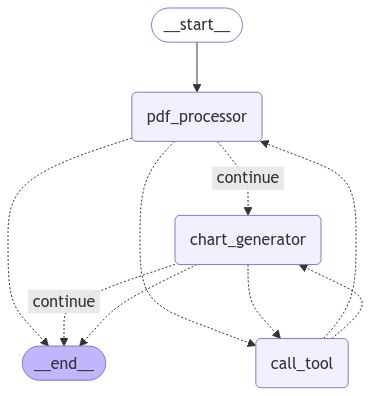

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'pdf_processor': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KyJJ5IZYAJDaByTCTicNd2K1', 'function': {'arguments': '{"pdf_file_path":"../example_scripts/lacers_reduced.pdf","schema":"{\\"Firm\\": \\"The name of the firm\\", \\"Number of Funds\\": \\"The number of funds managed by the firm\\", \\"Commitment\\": \\"The commitment amount in millions of dollars\\", \\"Percent of Total Comm\\": \\"The percentage of total commitment\\", \\"Exposure (FMV + Unfunded)\\": \\"The exposure including fair market value and unfunded commitments in millions of dollars\\", \\"Percent of Total Exposure\\": \\"The percentage of total exposure\\", \\"TVPI\\": \\"Total Value to Paid-In multiple\\", \\"Net IRR\\": \\"Net Internal Rate of Return as a percentage\\"}"}', 'name': 'process_pdf_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 328, 'total_tokens': 475, 'completion_tokens_details': {

{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AZbYouOAgOguEM3ZRwbN2yAX', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data\\nfirms = [\\n    \\"Vista Equity Partners\\",\\n    \\"ABRY Partners\\",\\n    \\"Advent International\\",\\n    \\"Thoma Bravo\\",\\n    \\"Platinum Equity\\",\\n    \\"Spark Management Partners\\",\\n    \\"New Enterprise Associates\\",\\n    \\"Technology Crossover Ventures\\",\\n    \\"EnCap Investments\\",\\n    \\"Hellman & Friedman\\"\\n]\\nnumber_of_funds = [7, 6, 5, 5, 4, 6, 4, 5, 4, 5]\\ncommitment = [185000000, 145000000, 145000000, 90000000, 112500000, 93750000, 95000000, 104500000, 120000000, 100463972]\\npercent_of_total_comm = [3.6, 2.8, 2.8, 1.8, 2.2, 1.8, 1.9, 2.0, 2.3, 2.0]\\nexposure = [192356158, 146947169, 132320692, 119164173, 105732861, 104048457, 103565654, 100481558, 97535330, 91816195]\\npercent_of_total_exposure = [5.4, 4.2, 3.7, 3.4, 3.0, 2.9, 2.9, 2.

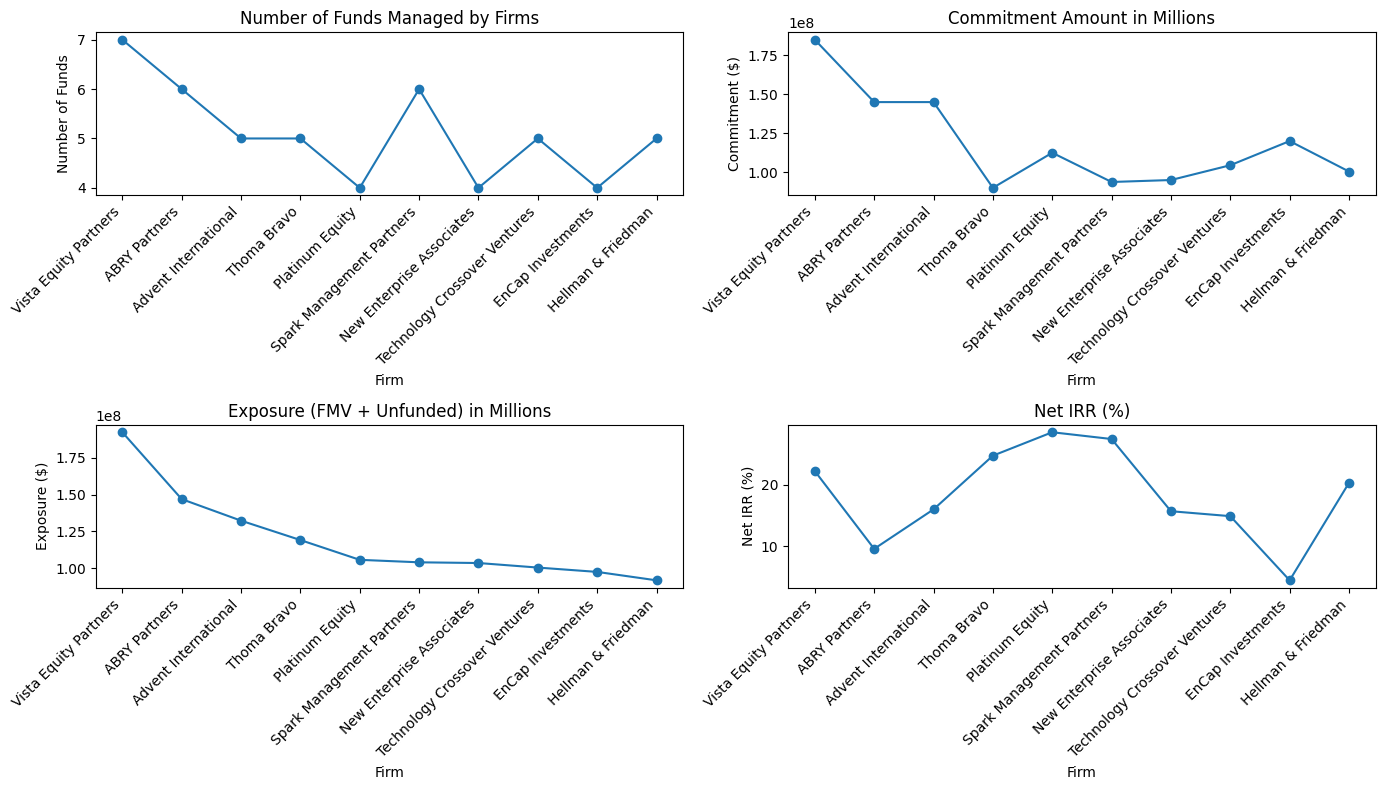

{'call_tool': {'messages': [ToolMessage(content='Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data\nfirms = [\n    "Vista Equity Partners",\n    "ABRY Partners",\n    "Advent International",\n    "Thoma Bravo",\n    "Platinum Equity",\n    "Spark Management Partners",\n    "New Enterprise Associates",\n    "Technology Crossover Ventures",\n    "EnCap Investments",\n    "Hellman & Friedman"\n]\nnumber_of_funds = [7, 6, 5, 5, 4, 6, 4, 5, 4, 5]\ncommitment = [185000000, 145000000, 145000000, 90000000, 112500000, 93750000, 95000000, 104500000, 120000000, 100463972]\npercent_of_total_comm = [3.6, 2.8, 2.8, 1.8, 2.2, 1.8, 1.9, 2.0, 2.3, 2.0]\nexposure = [192356158, 146947169, 132320692, 119164173, 105732861, 104048457, 103565654, 100481558, 97535330, 91816195]\npercent_of_total_exposure = [5.4, 4.2, 3.7, 3.4, 3.0, 2.9, 2.9, 2.8, 2.8, 2.6]\ntvpi = [2.07, 1.25, 1.64, 1.85, 1.64, 2.42, 1.60, 1.95, 1.11, 2.09]\nnet_irr = [22.2, 9.6, 16.0, 24.7, 28.5, 27.4, 15.7, 14.9, 

In [11]:
import json

events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Extract data under the schema {json.dumps(SCHEMA)} from the PDF under the path {PDF_FILE_PATH}," 
                f" then pass the schema and pdf path as inputs to the chart_generator agent to draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")